In [49]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

In [50]:
!pip install xgboost


In [51]:
df = pd.read_csv('Traffic data.csv')
df.head()

,ID,Datetime,Count
0,0,25-08-2012 00:00,8
1,1,25-08-2012 01:00,2
2,2,25-08-2012 02:00,6
3,3,25-08-2012 03:00,2
4,4,25-08-2012 04:00,2


In [52]:
df

,ID,Datetime,Count
0,0,25-08-2012 00:00,8
1,1,25-08-2012 01:00,2
2,2,25-08-2012 02:00,6
3,3,25-08-2012 03:00,2
4,4,25-08-2012 04:00,2
...,...,...,...
18283,18283,25-09-2014 19:00,868
18284,18284,25-09-2014 20:00,732
18285,18285,25-09-2014 21:00,702
18286,18286,25-09-2014 22:00,580


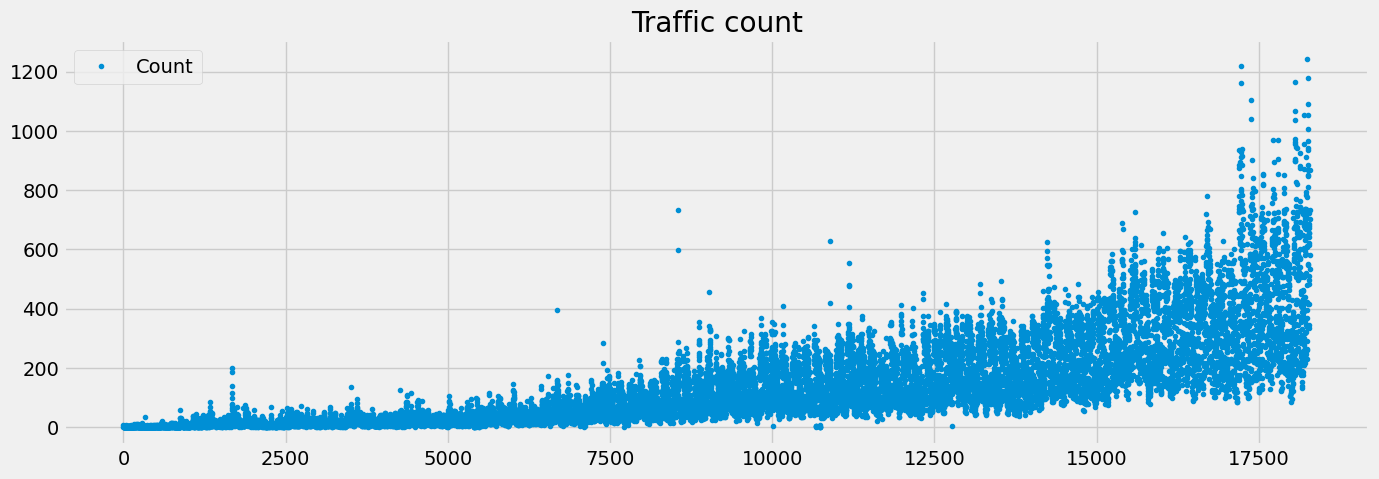

In [53]:
df.drop(df.columns[[0]], axis=1, inplace=False).plot(style='.', figsize=(15,5), title='Traffic count')
plt.show()

In [54]:
df

,ID,Datetime,Count
0,0,25-08-2012 00:00,8
1,1,25-08-2012 01:00,2
2,2,25-08-2012 02:00,6
3,3,25-08-2012 03:00,2
4,4,25-08-2012 04:00,2
...,...,...,...
18283,18283,25-09-2014 19:00,868
18284,18284,25-09-2014 20:00,732
18285,18285,25-09-2014 21:00,702
18286,18286,25-09-2014 22:00,580


## Preprocessing the dataset

In [55]:
df.isnull().sum()

ID          0
Datetime    0
Count       0
dtype: int64

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18288 entries, 0 to 18287
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ID        18288 non-null  int64 
 1   Datetime  18288 non-null  object
 2   Count     18288 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 428.8+ KB


In [57]:
df['Datetime'] = pd.to_datetime(df['Datetime'], format='%d-%m-%Y %H:%M')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18288 entries, 0 to 18287
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   ID        18288 non-null  int64         
 1   Datetime  18288 non-null  datetime64[ns]
 2   Count     18288 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 428.8 KB


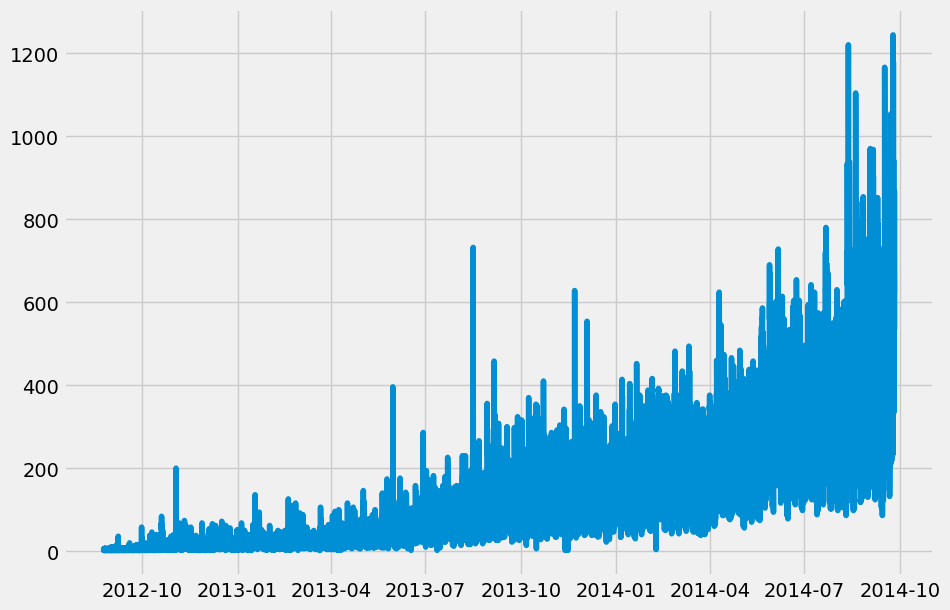

In [58]:
# EDA
plt.figure(figsize=(10,7))
plt.plot(df['Datetime'], df['Count'])
plt.show()

<Figure size 1000x700 with 0 Axes>

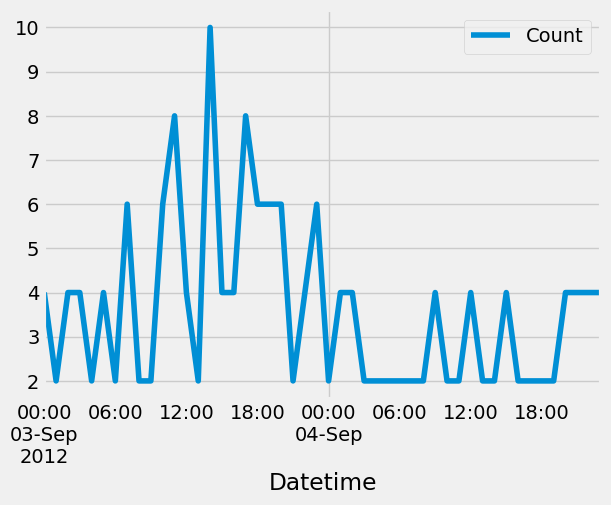

In [59]:
# EDA
plt.figure(figsize=(10,7))
df.iloc[216:264].plot(x='Datetime', y='Count')
plt.show()

## Format data for the model

In [60]:
df.index = df['Datetime']
df['y'] = df['Count']
df.drop(columns=['ID', 'Datetime', 'Count'], axis=1, inplace=True)
#df = df.resample('D').sum()
df.head()

,y
Datetime,
2012-08-25 00:00:00,8
2012-08-25 01:00:00,2
2012-08-25 02:00:00,6
2012-08-25 03:00:00,2
2012-08-25 04:00:00,2


In [61]:
df['ds'] = df.index
df.head()

,y,ds
Datetime,,
2012-08-25 00:00:00,8,2012-08-25 00:00:00
2012-08-25 01:00:00,2,2012-08-25 01:00:00
2012-08-25 02:00:00,6,2012-08-25 02:00:00
2012-08-25 03:00:00,2,2012-08-25 03:00:00
2012-08-25 04:00:00,2,2012-08-25 04:00:00


## Input Split

In [62]:
split_date = '18-Aug-2014'
df_train = df.loc[df.index <= split_date].copy()
df_test = df.loc[df.index > split_date].copy()

In [63]:
df_train.tail()

,y,ds
Datetime,,
2014-08-17 20:00:00,378,2014-08-17 20:00:00
2014-08-17 21:00:00,374,2014-08-17 21:00:00
2014-08-17 22:00:00,342,2014-08-17 22:00:00
2014-08-17 23:00:00,304,2014-08-17 23:00:00
2014-08-18 00:00:00,314,2014-08-18 00:00:00


In [64]:
df_test.head()

,y,ds
Datetime,,
2014-08-18 01:00:00,230,2014-08-18 01:00:00
2014-08-18 02:00:00,200,2014-08-18 02:00:00
2014-08-18 03:00:00,134,2014-08-18 03:00:00
2014-08-18 04:00:00,102,2014-08-18 04:00:00
2014-08-18 05:00:00,128,2014-08-18 05:00:00


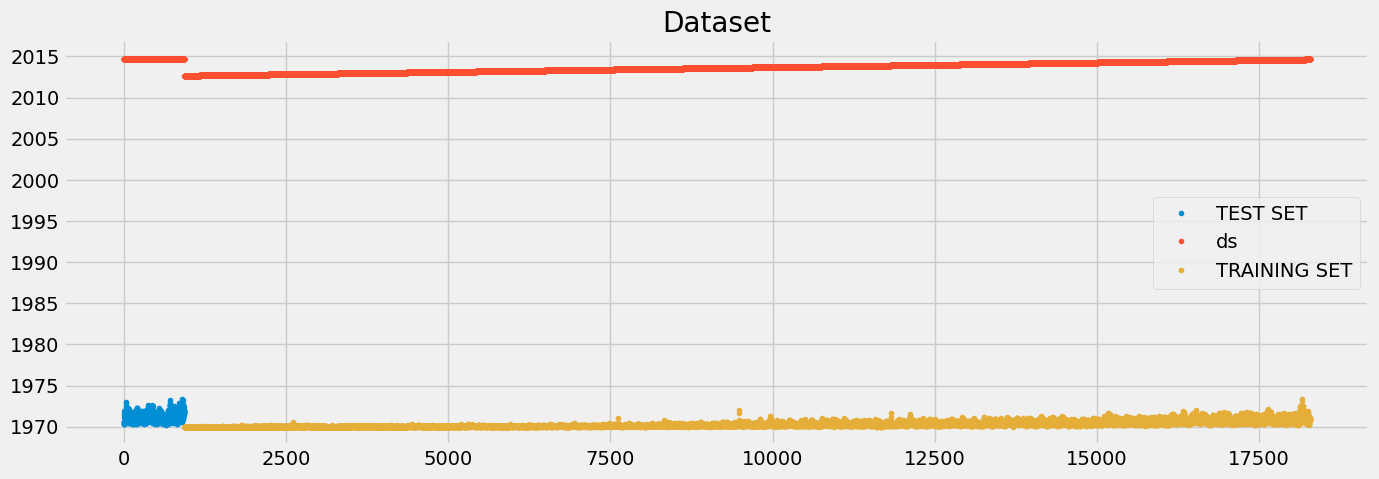

In [65]:
# Plot train and test so you can see where we have split
df_test \
    .rename(columns={'y': 'TEST SET'}) \
    .merge(df_train.rename(columns={'y': 'TRAINING SET'}),
          how='outer') \
    .plot(figsize=(15,5), title='Dataset', style='.')

plt.show()

In [66]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [67]:
X_train, y_train = create_features(df_train, label='ds')
X_test, y_test = create_features(df_test, label='ds')

/Users/ayushchakladar/opt/anaconda3/envs/Traffic/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  del sys.path[0]


## Model Training


In [80]:
reg = xgb.XGBRegressor(n_estimators=1000000)
reg.fit(X_train, y_train,eval_set=[(X_train, y_train), (X_test, y_test)],early_stopping_rounds=50)

[0]	validation_0-rmse:964152951022079744.00000	validation_1-rmse:996903156345796864.00000
[1]	validation_0-rmse:675046573628647552.00000	validation_1-rmse:707724712992665856.00000
[2]	validation_0-rmse:472719700932062016.00000	validation_1-rmse:505294925757966400.00000
[3]	validation_0-rmse:331162469587928960.00000	validation_1-rmse:363590780551513088.00000
[4]	validation_0-rmse:232176903113786240.00000	validation_1-rmse:264395665000197760.00000
[5]	validation_0-rmse:163037292053197696.00000	validation_1-rmse:194957675027796064.00000
[6]	validation_0-rmse:114853172795037168.00000	validation_1-rmse:146350169750488672.00000
[7]	validation_0-rmse:80430201989400608.00000	validation_1-rmse:104458421136109024.00000
[8]	validation_0-rmse:56325303715130080.00000	validation_1-rmse:74440552658502624.00000
[9]	validation_0-rmse:39445981426294264.00000	validation_1-rmse:53507645447692528.00000
[10]	validation_0-rmse:27626018743205552.00000	validation_1-rmse:38526108408237240.00000
[11]	validation_

[96]	validation_0-rmse:25920802984245.29297	validation_1-rmse:2100178022388664.25000
[97]	validation_0-rmse:25546383821550.61328	validation_1-rmse:2099508421343807.75000
[98]	validation_0-rmse:25048865069233.27734	validation_1-rmse:2098776025593407.25000
[99]	validation_0-rmse:24455606131408.07422	validation_1-rmse:2098776025593407.25000
[100]	validation_0-rmse:24270494468461.72266	validation_1-rmse:2099057046396491.25000
[101]	validation_0-rmse:24213950557261.34375	validation_1-rmse:2099015694633937.75000
[102]	validation_0-rmse:23990834351256.16406	validation_1-rmse:2099101281809855.25000
[103]	validation_0-rmse:23535975673645.71094	validation_1-rmse:2099101281809855.25000
[104]	validation_0-rmse:23153667098212.90234	validation_1-rmse:2099907457561512.00000
[105]	validation_0-rmse:22657930560953.04297	validation_1-rmse:2099996156452836.25000
[106]	validation_0-rmse:22363933613916.50000	validation_1-rmse:2092445330983830.25000
[107]	validation_0-rmse:22182711990648.87500	validation_1-

[192]	validation_0-rmse:10464248345028.71094	validation_1-rmse:2068487757660471.75000
[193]	validation_0-rmse:10370478237380.09570	validation_1-rmse:2068462996672514.25000
[194]	validation_0-rmse:10315691450581.02344	validation_1-rmse:2068462996672514.25000
[195]	validation_0-rmse:10256501088819.33203	validation_1-rmse:2068468099776693.50000
[196]	validation_0-rmse:10224076905454.38867	validation_1-rmse:2068468099776693.50000
[197]	validation_0-rmse:10187554847774.55859	validation_1-rmse:2068468099776693.50000
[198]	validation_0-rmse:10116784407649.92773	validation_1-rmse:2068777191392630.00000
[199]	validation_0-rmse:10074651292947.48242	validation_1-rmse:2068797297715856.00000
[200]	validation_0-rmse:9930152905441.14648	validation_1-rmse:2068822014835907.50000
[201]	validation_0-rmse:9872912770647.96484	validation_1-rmse:2068655158236222.50000
[202]	validation_0-rmse:9786244239461.20312	validation_1-rmse:2068652402893138.00000
[203]	validation_0-rmse:9710884222546.67969	validation_1-

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

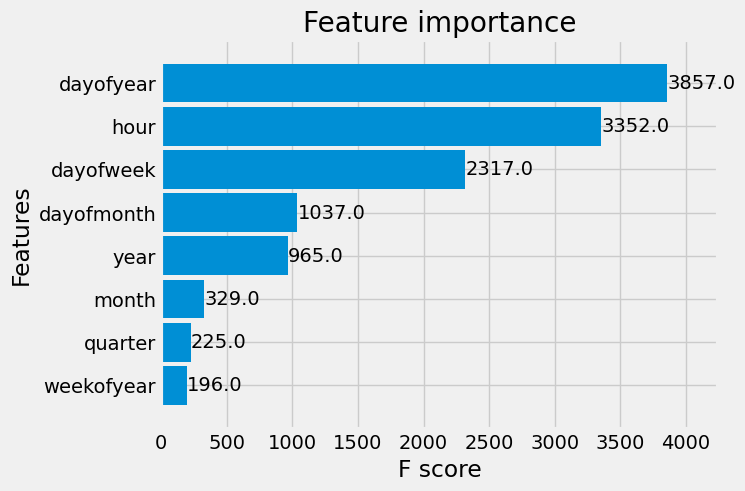

In [81]:
_ = plot_importance(reg, height=0.9)


In [82]:
df_test['Count_prediction'] = reg.predict(X_test)
df_all = pd.concat([df_train, df_test], sort=False)

In [83]:
_ = df_all[['ds','Count_prediction']].plot(figsize=(15, 5))

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7fcbbc5c4170> (for post_execute):


OverflowError: int too big to convert

OverflowError: int too big to convert

<Figure size 1500x500 with 1 Axes>

In [75]:
df_all

,y,ds,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,Count_prediction
Datetime,,,,,,,,,,,,
2012-08-25 00:00:00,8,2012-08-25 00:00:00,2012-08-25 00:00:00,0,5,3,8,2012,238,25,34,NaN
2012-08-25 01:00:00,2,2012-08-25 01:00:00,2012-08-25 01:00:00,1,5,3,8,2012,238,25,34,NaN
2012-08-25 02:00:00,6,2012-08-25 02:00:00,2012-08-25 02:00:00,2,5,3,8,2012,238,25,34,NaN
2012-08-25 03:00:00,2,2012-08-25 03:00:00,2012-08-25 03:00:00,3,5,3,8,2012,238,25,34,NaN
2012-08-25 04:00:00,2,2012-08-25 04:00:00,2012-08-25 04:00:00,4,5,3,8,2012,238,25,34,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2014-09-25 19:00:00,868,2014-09-25 19:00:00,2014-09-25 19:00:00,19,3,3,9,2014,268,25,39,1.408141e+18
2014-09-25 20:00:00,732,2014-09-25 20:00:00,2014-09-25 20:00:00,20,3,3,9,2014,268,25,39,1.408145e+18
2014-09-25 21:00:00,702,2014-09-25 21:00:00,2014-09-25 21:00:00,21,3,3,9,2014,268,25,39,1.408177e+18
